In [5]:
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import datetime
warnings.filterwarnings('ignore')

In [14]:
data = pd.read_csv('task1.csv', index_col=['data'])

In [15]:
data.head()

,value
data,
01.01.2019,14.77
02.01.2019,14.83
03.01.2019,16.20
05.01.2019,15.50
06.01.2019,15.16


In [16]:
# Строим временную зависимость данных
fig = px.line(data,title="Value data dependancy")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

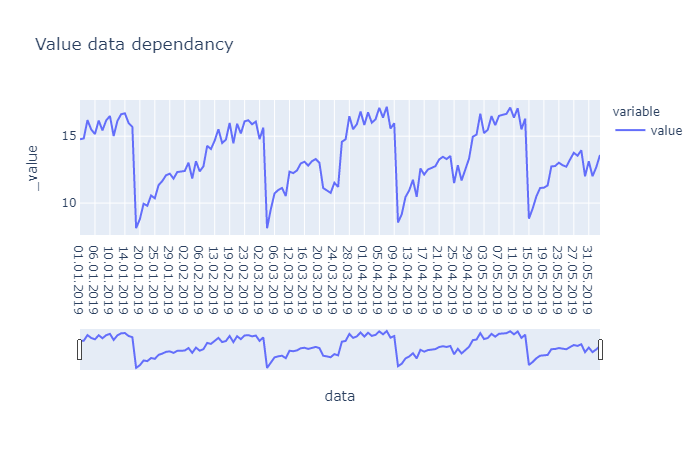

In [20]:
from IPython.display import Image
Image(filename='plot1.png') 

#### Из графика явно видна сезонность

In [4]:
px.line(data.rolling(window=30).mean()[30:], title='Rolling mean trend, window = month')

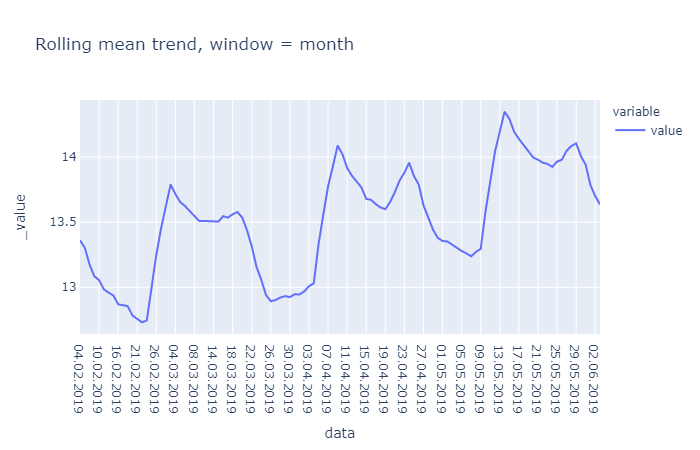

In [21]:
Image(filename='plot2.png') 

#### После построения графика скользящей средней по 30 наблюдениям, отчетливо заметно наличие возрастающего тренда

In [5]:
data.head()

,value
data,
01.01.2019,14.77
02.01.2019,14.83
03.01.2019,16.20
05.01.2019,15.50
06.01.2019,15.16


In [6]:
def timeseriesCVscore(x):
    errors = []
    values = data.value
    alpha, beta, gamma = x
    
    #Применяет экспоненциальное сглаживанеи
    model = ExponentialSmoothing(data.value, trend='add', seasonal='add', seasonal_periods=35, damped=True)
    #Обучаем модель на переданных параметрах
    fitted = model.fit(optimized=True, smoothing_level = alpha, smoothing_slope=beta, smoothing_seasonal=gamma)

    #Строим предсказания 
    predictions = fitted.predict(start=data.value.index[0], end=data.value.index[-1])
    actual = values
    
    #Возвращаем корень из среднеквадратичной ошибки
    return mean_squared_error(predictions, actual, squared=False)

In [7]:
%%time
x = [0, 0, 0] 
# ищем оптимальные параметры модели
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.5828712085445965 0.013231114285900958 0.0
Wall time: 4.23 s


In [8]:
# Обучаем модель с оптимальными параметрами

model = ExponentialSmoothing(data.value, trend='add', seasonal='add', seasonal_periods=35, damped=True)
fitted = model.fit(optimized=True, smoothing_level = alpha_final, smoothing_slope=beta_final, smoothing_seasonal=gamma_final)

In [9]:
# Восстанавлиаем исходную выборку с помощью обученной модели Хольта-Винтерса

data2 = data.copy()
data2["Holt-Winters"] = fitted.fittedvalues

In [10]:
fig = px.line(data2, title='RMSE = {}'.format(mean_squared_error(data.value, data2["Holt-Winters"], squared=False)))
fig.update_xaxes(rangeslider_visible=True)
fig.show()

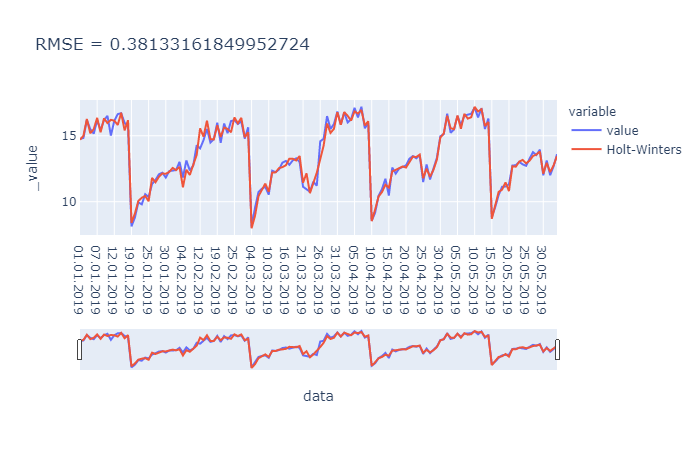

In [22]:
Image(filename='plot3.png') 

#### Полученная модель хорошо восстанавливает исходные данные

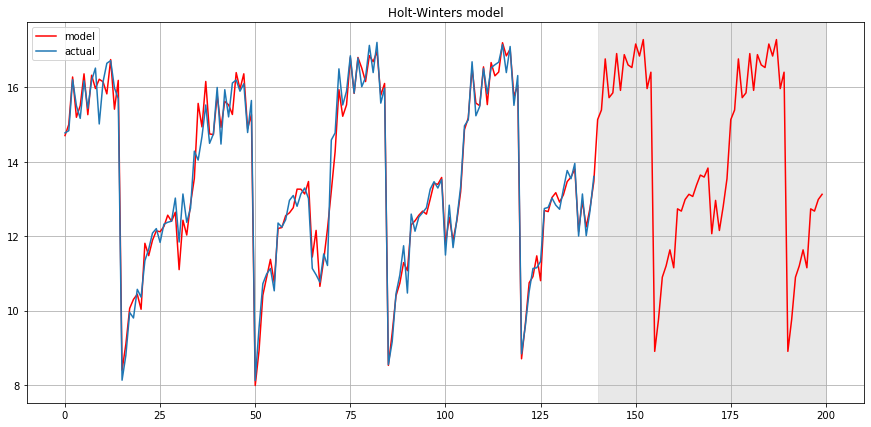

In [11]:
# строим предсказания с 4.06.2019 до 1.08.2019

predictions = fitted.predict(start=data.shape[0], end=data.shape[0] +  59)
predictions = data2["Holt-Winters"].append(predictions).values
actual = data2.value.values
plt.figure(figsize=(15, 7))
plt.plot(predictions, color='r', label="model")
plt.title("Holt-Winters model")
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(predictions), alpha=0.5, color='lightgrey')
plt.grid(True)

In [12]:
result = pd.DataFrame(fitted.predict(start=data.shape[0], end=data.shape[0] + 59))
result.columns = ['prediction']

base = datetime.datetime(2019, 8, 1)
date_list = np.array([base - datetime.timedelta(days=x) for x in range(60)])[::-1]

result.set_index(date_list)

,prediction
2019-06-03,15.127826
2019-06-04,15.384768
2019-06-05,16.756696
2019-06-06,15.716134
2019-06-07,15.845569
2019-06-08,16.900000
2019-06-09,15.911935
2019-06-10,16.871364
2019-06-11,16.595792
2019-06-12,16.525226
